# Clonar el proyecto
*Nota: Asegurarse de estar trabajando con la GPU.*

In [1]:
!git clone https://github.com/gangweix/Fast-ACVNet.git
!git clone https://github.com/nick3153/Depth-Estimation-with-StereoThermal-Images.git
%cd Fast-ACVNet

Cloning into 'Fast-ACVNet'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 213 (delta 46), reused 31 (delta 31), pack-reused 152 (from 1)
Receiving objects: 100% (213/213), 86.10 MiB | 18.96 MiB/s, done.
Resolving deltas: 100% (96/96), done.
Updating files: 100% (50/50), done.
Cloning into 'Depth-Estimation-with-StereoThermal-Images'...
remote: Enumerating objects: 6149, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6149 (delta 1), reused 0 (delta 0), pack-reused 6147 (from 3)
Receiving objects: 100% (6149/6149), 1.68 GiB | 26.84 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Updating files: 100% (152/152), done.
/content/Fast-ACVNet


# Instalar dependencias necesarias

In [2]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python
!pip install scikit-image
!pip install tensorboard
!pip install matplotlib
!pip install tqdm
!pip install timm==0.5.4

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unin

# Código

In [111]:
#@title Funciones necesarias
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import numpy as np
from torchvision import transforms
import cv2
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

def get_colormapped(image, cmap):
    # Normalizar a [0, 1] para colormap
    norm = Normalize(vmin=np.min(image), vmax=np.max(image))
    image_normalized = norm(image)

    # Aplicar colormap
    colored_image = cmap(image_normalized)

    return colored_image

def normalize(img):
    image = ((img - img.min()) / (img.max() - img.min())) * 255.0
    return image.astype(np.uint8)

def intensity_binding(img, lower_percentile:int=1, upper_percentile:int=99):
    # Calcular los percentiles
    low = np.percentile(img, lower_percentile)
    high = np.percentile(img, upper_percentile)

    # Recortar al rango [low, high]
    img_clipped = np.clip(img, low, high)

    img_norm = normalize(img_clipped)

    return img_norm

def apply_CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def bilateral_filtering(img):
    return cv2.bilateralFilter(img, d=5, sigmaColor=15, sigmaSpace=3)

def align_contrast(imgL, imgR):
    meanL = np.mean(imgL)
    meanR = np.mean(imgR)

    if meanR < meanL:
      imageR = imgR * (meanL/meanR)
      return imgL, imageR
    elif meanL < meanR:
      imageL = imgL * (meanR/meanL)
      return imageL, imgR

    return imgL, imgR

def preprocess_thermal_image(img):
    if np.max(img) < 35000:
      image = normalize(img)
    else:
      # Eliminar outlayers
      image = intensity_binding(img)

    # Ecualizacion del histograma con clahe
    image = apply_CLAHE(image)

    # Eliminacion de ruido
    image = bilateral_filtering(image)

    return image.astype(np.uint8)

def preprocess_images(imgL, imgR):
    imageL = cv2.imread(imgL, cv2.IMREAD_UNCHANGED)
    imageR = cv2.imread(imgR, cv2.IMREAD_UNCHANGED)
    imageL = preprocess_thermal_image(imageL)
    imageR = preprocess_thermal_image(imageR)

    imageL, imageR = align_contrast(imageL, imageR)

    return Image.fromarray(imageL.astype(np.uint8)), Image.fromarray(imageR.astype(np.uint8))

def depth_to_disparity(depth, focal_length = 406.33233091474426, baseline = 0.2458492526627874):
    # Evitar división por cero
    depth = np.clip(depth, a_min=1e-6, a_max=None)
    disparity = (focal_length * baseline) / depth
    return disparity

def predict_disparity(model, left_path, right_path, output_dir='./disp_rgb/'):
    os.makedirs(output_dir, exist_ok=True)

    # Cargar imágenes RGB con PIL
    limg = Image.open(left_path).convert('RGB')
    rimg = Image.open(right_path).convert('RGB')

    # Asegurar tamaños múltiples de 32
    w, h = limg.size
    wi, hi = (w // 32 + 1) * 32, (h // 32 + 1) * 32
    limg = limg.crop((w - wi, h - hi, w, h))
    rimg = rimg.crop((w - wi, h - hi, w, h))

    # Preprocesamiento: convertir a tensor y normalizar
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    limg_tensor = transform(limg).unsqueeze(0).cuda()
    rimg_tensor = transform(rimg).unsqueeze(0).cuda()

    # Inferencia
    model.eval()
    with torch.no_grad():
        pred_disp = model(limg_tensor, rimg_tensor)[-1]
        pred_disp = pred_disp[:, hi - h:, wi - w:]

    # Convertir a numpy
    pred_np = pred_disp.squeeze().cpu().numpy()

    # Guardar como imagen coloreada
    output_path = os.path.join(output_dir, 'disp_rgb.png')
    pred_np_scaled = np.round(pred_np * 256).round().astype(np.uint16)
    disp_color = cv2.applyColorMap(cv2.convertScaleAbs(pred_np_scaled, alpha=0.01), cv2.COLORMAP_JET)
    cv2.imwrite(output_path, disp_color)

    print(f"Disparidad guardada en: {output_path}")

def test_thermal_pairs(left_imgs, right_imgs):
    os.makedirs('./disp_thermal/', exist_ok=True)

    for i in range(len(left_imgs)):
        limg, rimg = preprocess_images(left_imgs[i], right_imgs[i])

        limg = np.stack([limg]*3, axis=-1)
        rimg = np.stack([rimg]*3, axis=-1)

        limg_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])(limg).unsqueeze(0).cuda()

        rimg_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])(rimg).unsqueeze(0).cuda()

        # Inferencia
        model.eval()
        with torch.no_grad():
            pred_disp = model(limg_tensor, rimg_tensor)[-1]

        pred_np = pred_disp.squeeze().cpu().numpy()
        pred_np_save = (pred_np * 256).round().astype(np.uint16)

        filename = os.path.join('./disp_thermal/', f'thermal_disp_{i}.png')
        cv2.imwrite(filename, cv2.applyColorMap(
            cv2.convertScaleAbs(pred_np_save, alpha=0.01), cv2.COLORMAP_JET),
            [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

        print(f'Guardado: {filename}')


# ========================================
# Funcion del repositorio de FIReStereo
# ========================================
def visualize_depth_as_numpy(depth, cmap="jet", is_sparse=True):
    """
    Args:
        data (HxW): depth data
        cmap: color map (inferno, plasma, jet, turbo, magma, rainbow)
    Returns:
        vis_data (HxWx3): depth visualization (RGB)
    """

    # x = depth.cpu().numpy()
    x = np.nan_to_num(depth)  # change nan to 0

    inv_depth = 1 / (x + 1e-6)

    if is_sparse:
        vmax = 1 / np.percentile(x[x != 0], 5)
    else:
        vmax = np.percentile(inv_depth, 95)

    normalizer = matplotlib.colors.Normalize(vmin=inv_depth.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap=cmap)
    vis_data = (mapper.to_rgba(inv_depth)[:, :, :3] * 255).astype(np.uint8)
    if is_sparse:
        vis_data[inv_depth > vmax] = 0
    return vis_data


In [121]:
#@title Cargar el modelo entrenado
import torch
import torch.nn as nn
from models import __models__

model = __models__['Fast_ACVNet'](192, False)
model = nn.DataParallel(model).cuda()
state_dict = torch.load('/content/Depth-Estimation-with-StereoThermal-Images/pretrained_model/generalization.ckpt') #  Por defecto /content/Depth-Estimation-with-StereoThermal-Images/pretrained_model/...ckpt
model.load_state_dict(state_dict['model'])
model.eval()

DataParallel(
  (module): Fast_ACVNet(
    (feature): Feature(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU6(inplace=True)
      (block0): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU6(inplace=True)
            (se): Identity()
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
      )
      (block1): Sequential(
        (0): Sequential(
          (0): InvertedResidual(
           

Disparidad guardada en: ./disp_rgb/disp_rgb.png


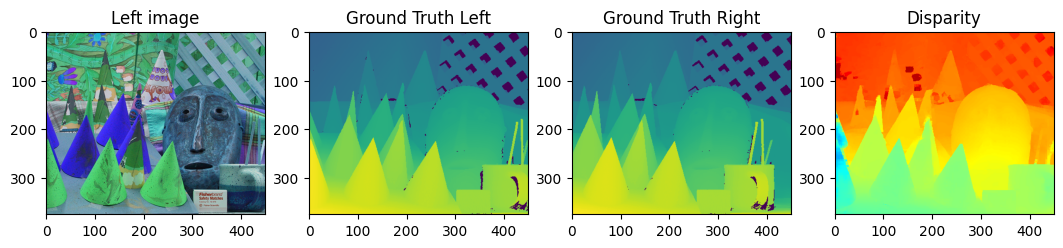

In [115]:
#@title Ejemplo con un par estereo RGB
import cv2
import matplotlib.pyplot as plt

predict_disparity(model,
                  left_path='/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/rgb/left.png',
                  right_path='/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/rgb/right.png')

disp_rgb = cv2.imread('/content/Fast-ACVNet/disp_rgb/disp_rgb.png', cv2.IMREAD_UNCHANGED)
gtL_rgb = cv2.imread('/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/rgb/gtL.png', cv2.IMREAD_UNCHANGED)
gtR_rgb = cv2.imread('/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/rgb/gtR.png', cv2.IMREAD_UNCHANGED)
imgL = cv2.imread('/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/rgb/left.png', cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(13,11))
plt.subplot(141)
plt.imshow(imgL)
plt.title('Left image')
plt.subplot(142)
plt.imshow(gtL_rgb)
plt.title('Ground Truth Left')
plt.subplot(143)
plt.imshow(gtR_rgb)
plt.title('Ground Truth Right')
plt.subplot(144)
plt.imshow(disp_rgb, cmap='jet')
plt.title('Disparity')
plt.show()

In [116]:
#@title Cargar las imagenes termicas
import os

left_dir = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/hawkins_4/left/'
right_dir = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/hawkins_4/right/'

left_imgs = sorted([os.path.join(left_dir, f) for f in os.listdir(left_dir) if f.endswith('.png')])
right_imgs = sorted([os.path.join(right_dir, f) for f in os.listdir(right_dir) if f.endswith('.png')])

assert len(left_imgs) == len(right_imgs), "El número de imágenes izquierdas y derechas no coincide."

In [117]:
test_thermal_pairs(left_imgs, right_imgs)

Guardado: ./disp_thermal/thermal_disp_0.png
Guardado: ./disp_thermal/thermal_disp_1.png
Guardado: ./disp_thermal/thermal_disp_2.png
Guardado: ./disp_thermal/thermal_disp_3.png
Guardado: ./disp_thermal/thermal_disp_4.png
Guardado: ./disp_thermal/thermal_disp_5.png
Guardado: ./disp_thermal/thermal_disp_6.png
Guardado: ./disp_thermal/thermal_disp_7.png
Guardado: ./disp_thermal/thermal_disp_8.png
Guardado: ./disp_thermal/thermal_disp_9.png
Guardado: ./disp_thermal/thermal_disp_10.png
Guardado: ./disp_thermal/thermal_disp_11.png
Guardado: ./disp_thermal/thermal_disp_12.png
Guardado: ./disp_thermal/thermal_disp_13.png
Guardado: ./disp_thermal/thermal_disp_14.png
Guardado: ./disp_thermal/thermal_disp_15.png
Guardado: ./disp_thermal/thermal_disp_16.png
Guardado: ./disp_thermal/thermal_disp_17.png


<ipython-input-118-90eda11b40b7>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet_r')


Text(0.5, 1.0, 'Depth calculado')

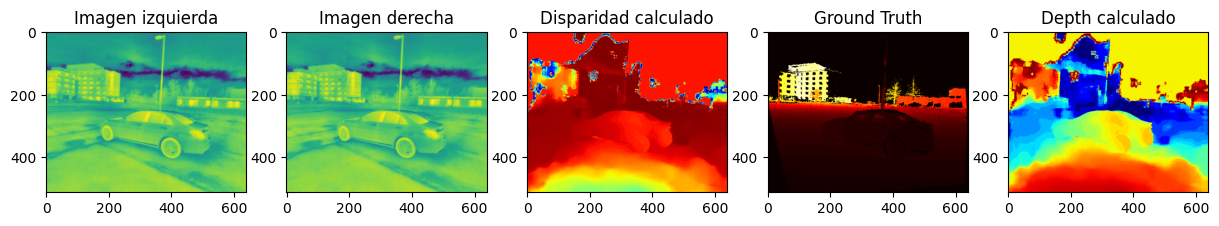

In [118]:
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
from PIL import Image

colormap = cm.get_cmap('jet_r')

path = '/content/Fast-ACVNet/disp_thermal/'
pathgt = '/content/Depth-Estimation-with-StereoThermal-Images/demo_imgs/hawkins_4/depth/'

disp_imgs_path = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.png')])
gt_imgs_path = sorted([os.path.join(pathgt, f) for f in os.listdir(pathgt) if f.endswith('.png')])

gt_imgs = []
disp_imgs =[]

for i in range(len(gt_imgs_path)):
  gt_imgs.append(cv2.imread(gt_imgs_path[i], cv2.IMREAD_GRAYSCALE))
  disp_imgs.append(cv2.imread(disp_imgs_path[i], cv2.IMREAD_GRAYSCALE))

imgL, imgR = preprocess_images(left_imgs[17], right_imgs[17])

f = 406.33233091474426
baseline = 0.24584925266278748
depth_imgs = [f*baseline/disp for disp in disp_imgs]

# Mostrar una imagen de ejemplo
plt.figure(figsize=(15,8))
plt.subplot(151)
plt.imshow(imgL)
plt.title('Imagen izquierda')
plt.subplot(152)
plt.imshow(imgR)
plt.title('Imagen derecha')
plt.subplot(153)
plt.imshow(get_colormapped(disp_imgs[17], cmap=colormap))
plt.title('Disparidad calculado')
plt.subplot(154)
plt.imshow(gt_imgs[17], cmap='hot')
plt.title('Ground Truth')
plt.subplot(155)
plt.imshow(get_colormapped(depth_imgs[17], cmap=colormap))
plt.title('Depth calculado')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
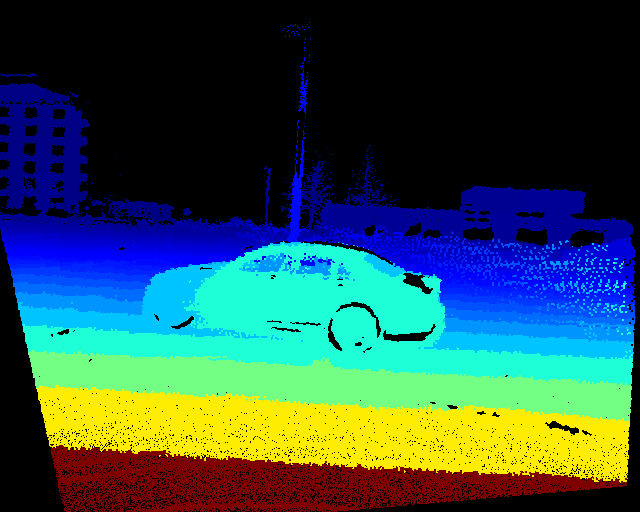

In [119]:
visualize_depth_as_numpy(gt_imgs[0])

array([[[  0, 104, 255],
        [  0, 104, 255],
        [  0, 104, 255],
        ...,
        [147, 255,  99],
        [147, 255,  99],
        [131, 255, 115]],

       [[  0, 104, 255],
        [  0, 104, 255],
        [  0, 104, 255],
        ...,
        [147, 255,  99],
        [147, 255,  99],
        [147, 255,  99]],

       [[  0, 104, 255],
        [  0, 104, 255],
        [  0, 104, 255],
        ...,
        [147, 255,  99],
        [147, 255,  99],
        [131, 255, 115]],

       ...,

       [[255, 152,   0],
        [255, 152,   0],
        [255, 152,   0],
        ...,
        [  0,  32, 255],
        [  0,  32, 255],
        [  0,  32, 255]],

       [[255, 152,   0],
        [255, 152,   0],
        [255, 152,   0],
        ...,
        [  0,  32, 255],
        [  0,  32, 255],
        [  0,  32, 255]],

       [[255, 152,   0],
        [255, 152,   0],
        [255, 152,   0],
        ...,
        [  0,  32, 255],
        [  0,  32, 255],
        [  0,  32, 255]]], dtype=uint8)
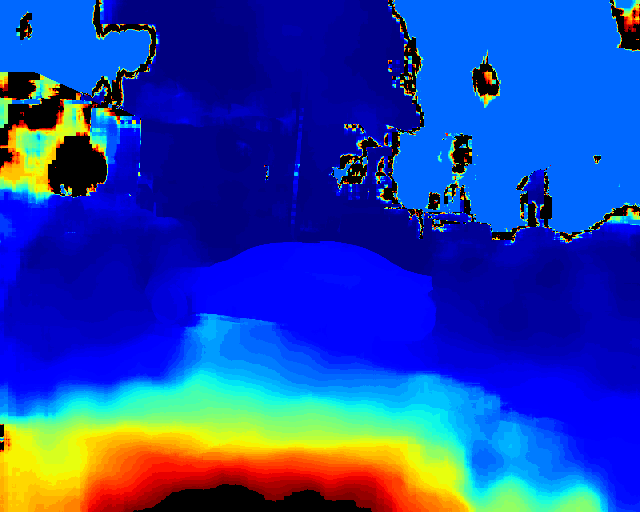

In [120]:
visualize_depth_as_numpy(depth_imgs[0])